In [1]:
import os
import sys
sys.path.append("../") # go to parent dir
import glob
import time
import pathlib
import logging
import numpy as np
from mpi4py import MPI
comm = MPI.COMM_WORLD
from scipy.sparse import linalg as spla
from dedalus.tools.config import config
from simple_sphere import SimpleSphere, TensorField, TensorSystem
import equations
import matplotlib.pyplot as plt
%matplotlib inline
import cartopy.crs as ccrs
from dedalus.extras import plot_tools
import logging
from mpl_toolkits import mplot3d
logger = logging.getLogger(__name__)

In [19]:
inds = [25, 26, 27, 28, 29, 30]
band = [None]*len(inds)

count = 0

for i in inds:
    print(i)
    input_folder = "/Users/Rohit/Documents/research/active_matter_spheres/scripts/data/sphere%i" %(i)
    
    first_frame = 1
    last_frame = len(glob.glob1("".join([input_folder,'/']),"*.npz"))
    t_arr = np.zeros(last_frame)

    for ind in range(first_frame, last_frame + 1, 1):
        
        if np.mod(ind, 100)==0: logger.info('Frame: %i' %(ind))
        
        with np.load(os.path.join(input_folder, 'output_%i.npz' %(ind))) as file:
            if ind == first_frame + comm.rank:
                phi = file['phi']
                theta = file['theta']
                L_max = len(theta)-1
                S_max = 4
                simplesphere = SimpleSphere(L_max, S_max)
                omega = TensorField(simplesphere, rank=0)
                coeffs_all = np.zeros((last_frame,L_max+1, L_max+1), dtype=complex)

            om = file['om']
            time = file['t'][0]
            t_arr[ind-1] = time

        # assign loaded data
        omega.component_fields[0]['g'] = om
        # spectral transform
        omega.forward_phi()
        omega.forward_theta()
        coeffs = omega.coeffs
    
        #coeff1[ind-1] = coeffs[m_1][ell_1-m_1]
        #coeff2[ind-1] = coeffs[m_2][ell_2-m_2]
        for m in range(len(coeffs)):
            coeffs_all[ind-1, m, m:] = coeffs[m]

    #calculate energy 
    Em0 = np.zeros(t_arr.shape)
    E = np.zeros(t_arr.shape)

    for m in range(L_max+1):
        for ell in range(L_max+1):
            if ell!=0:
                if m==0:
                    Em0 = Em0 + (np.abs(coeffs_all[:,m,ell])**2)/(ell*(ell+1))
                E = E + (np.abs(coeffs_all[:,m,ell])**2)/(ell*(ell+1))

    band[count] = np.divide(Em0, E)
    count += 1
    

25
2019-04-25 16:35:47,984 __main__ 0/1 INFO :: Frame: 100
2019-04-25 16:35:51,227 __main__ 0/1 INFO :: Frame: 200
2019-04-25 16:35:53,907 __main__ 0/1 INFO :: Frame: 300
2019-04-25 16:35:56,743 __main__ 0/1 INFO :: Frame: 400
2019-04-25 16:35:59,583 __main__ 0/1 INFO :: Frame: 500
2019-04-25 16:36:02,281 __main__ 0/1 INFO :: Frame: 600
2019-04-25 16:36:04,995 __main__ 0/1 INFO :: Frame: 700
2019-04-25 16:36:07,797 __main__ 0/1 INFO :: Frame: 800
2019-04-25 16:36:10,514 __main__ 0/1 INFO :: Frame: 900
2019-04-25 16:36:13,249 __main__ 0/1 INFO :: Frame: 1000
26
2019-04-25 16:36:26,904 __main__ 0/1 INFO :: Frame: 100
2019-04-25 16:36:29,671 __main__ 0/1 INFO :: Frame: 200
2019-04-25 16:36:32,284 __main__ 0/1 INFO :: Frame: 300
2019-04-25 16:36:34,991 __main__ 0/1 INFO :: Frame: 400
2019-04-25 16:36:37,605 __main__ 0/1 INFO :: Frame: 500
2019-04-25 16:36:40,274 __main__ 0/1 INFO :: Frame: 600
2019-04-25 16:36:42,901 __main__ 0/1 INFO :: Frame: 700
2019-04-25 16:36:45,634 __main__ 0/1 INFO

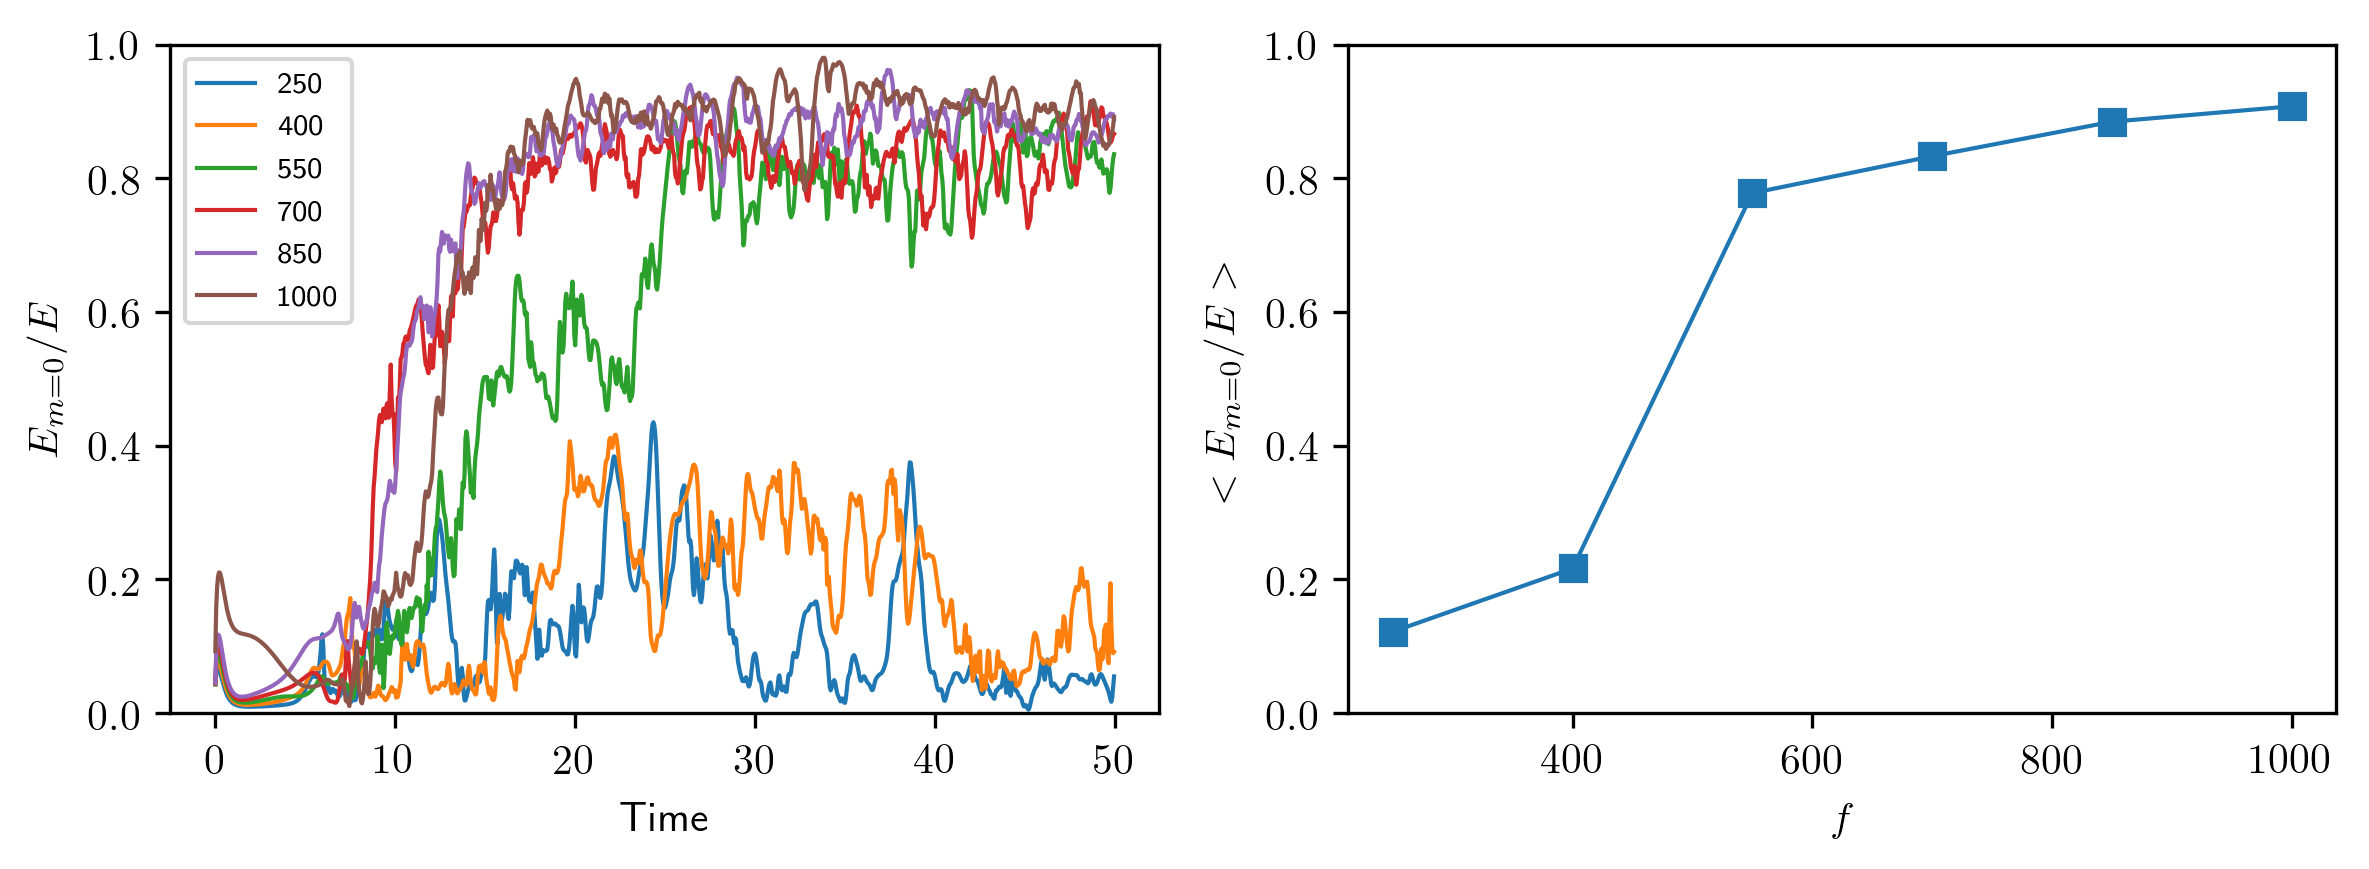

In [70]:
fspin = [250, 400, 550, 700, 850, 1000]
plt.rc('text', usetex=True)

plt.figure(figsize=(8,3), dpi=300)

ax = plt.subplot(121)

for i in range(len(band)):
    ax.plot(t_arr, band[i], linewidth=1)

ax.legend(fspin, prop={'size': 7})
ax.set_xlabel('Time')
ax.set_ylabel(r'$E_{m=0}/E$')
ax.set_ylim([0,1])

#find the time-average of the bandedness
start_time = 30
dt = t_arr[1] - t_arr[2]
start_ind = int(np.floor(start_time/dt))
band_end = [None]*len(fspin)

for i in range(len(band)):
    band_end[i] = np.mean(band[i][start_ind:])

ax = plt.subplot(122)
ax.plot(fspin, band_end, '-s', linewidth=1)
ax.set_ylabel(r'$<E_{m=0}/E>$')
ax.set_xlabel(r'$f$')
ax.set_ylim([0,1])

plt.tight_layout()

plt.savefig('../plots/bandedness.eps')   

In [6]:
list(range(100, 1001, 100))

[100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]